## **Amazon reviews Analysis**

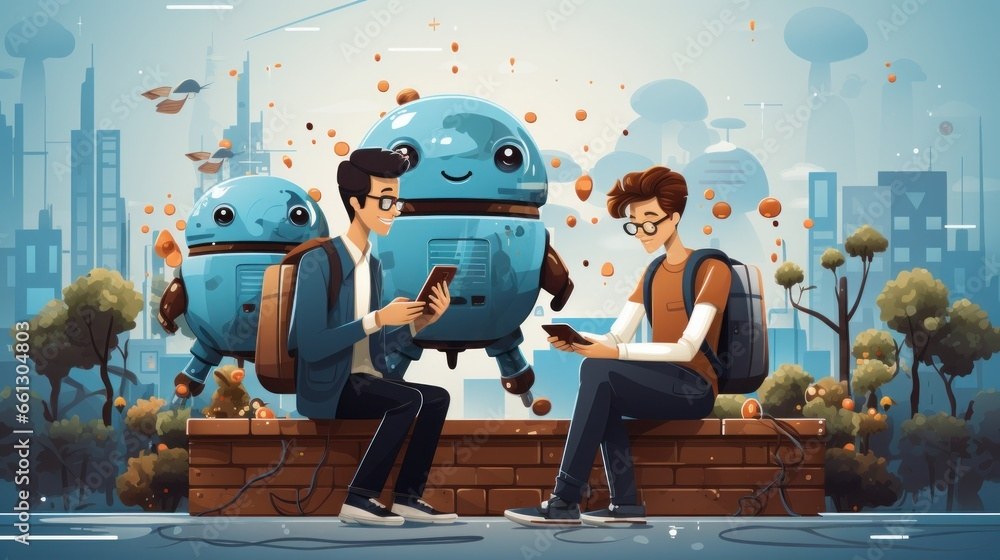

In [3]:
# load libraries
import pandas as pd
import numpy as np
import re
import os
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from bs4 import BeautifulSoup     # pulls data out of XML and HTML files
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
!pip install wget
import wget


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a24998ccd2e4ec873887bea900feb38dc8144393da6eceed1d371c83328d48f0
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


load the dataset

In [4]:
data=pd.read_csv("/content/drive/MyDrive/AmazonReviews.zip")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


Entries in the dataset

In [5]:
print(data['Text'].shape)

(568454,)


Display some of the data

In [6]:
data[['Score','Text','Summary']].sample(5)

,Score,Text,Summary
567280,5,beautiful flowers - great price and good customer service. arrived quickly - will use this company again in future as i had an issue with my first order and it was dealt with quickly and professi...,good customer service
231835,4,My son is 11 month and only just now cutting his first tooth. It's hard to find snacks on-the-go for him that don't require teeth. I recently came across the Plum Organics Teensy Fruits and took a...,Nice snack for babies
38654,5,Now I know what a pound of catnip looks like. I just cracked it open and the cat is going bonkers. I hope I get through the whole thing before it (if it) goes stale. Good price if you don't have t...,good deal
113343,5,"I've become a big fan of whole grain, and Kashi cereals in particular. Some of Kashi's bars can be a bit dry, but the Dark Chocolate and Coconut is my standby, go to ""granola"" bar. The dark chocol...",The best Kashi fruit and grain bar. Easily.
432298,4,I love this stuff. I'm on my second bottle. Not too hot that you can't pour it on your tacos (YMMV). Slightly garlicky but not overbearingly so. It's not vinegary like Tabasco and it's thick k...,Green Goddess


To Remove any duplicate entries

In [7]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

Setting score parameters labels

In [8]:
labels = data['Score']
labels[labels<=2] = 0
labels[labels>=3] = 1

Map words to colloquial terms

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

Print out the first 10 entries in the data to view it to decide what to do for data cleaning.

In [10]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [11]:
!pip install nltk

download the stopwords library.

In [12]:
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Create a function to clean the text. Remove whitespace, HTML characters, punctuation, etc.

In [13]:
def text_cleaner(text):
    # Convert text to lowercase
    newString = text.lower()
    # Remove HTML tags
    newString = BeautifulSoup(newString, "lxml").text
    # Remove text inside parentheses
    newString = re.sub(r'\([^)]*\)', '', newString)
    # Remove double quotes
    newString = re.sub('"', '', newString)
    # Expand contractions if possible
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # Remove 's (apostrophe followed by s)
    newString = re.sub(r"'s\b", "", newString)
    # Remove non-alphabetic characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Tokenize the text and remove stopwords
    tokens = [w for w in newString.split() if not w in stop_words]
    # Remove short words
    long_words = [word for word in tokens if len(word) >= 3]
    return (" ".join(long_words)).strip()

# Store the cleaned text in a list
cleaned_text = [text_cleaner(t) for t in data['Text']]


Create a function to clean the summary text

In [14]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

# Call the summary_cleaner function and store the cleaned summaries in a list
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

# store the cleaned text and summaries in a dictionary
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
# drop rows with null values
data.dropna(axis=0,inplace=True)


Add the text _START_ and _END_ to the summaries to easily identify they are the summaries.

In [15]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

Print the first 5 reviews and their summaries.

In [16]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("Score:",data['Score'][i])
    print("\n")


Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_
Score: 1


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_
Score: 0


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_
Score: 1


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_
Score: 0


Review: great taffy great price wide assortment

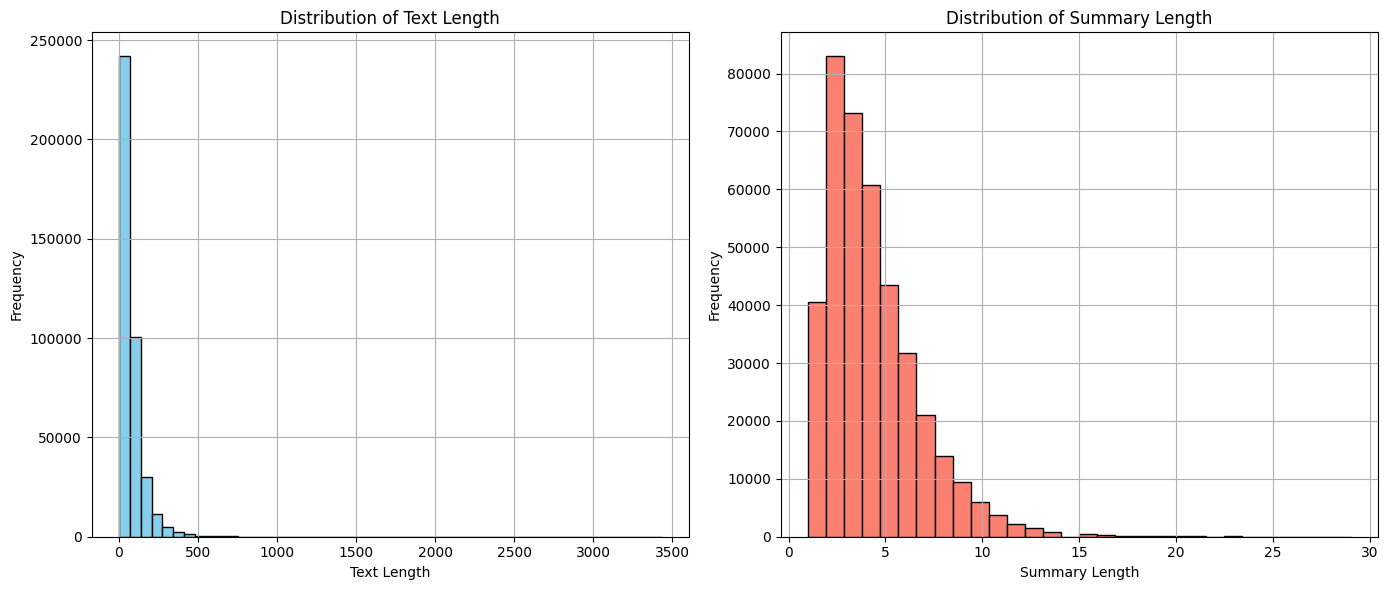

In [17]:
import matplotlib.pyplot as plt

# Calculate the length of each text and summary
text_lengths = [len(text.split()) for text in data['Text']]
summary_lengths = [len(summary.split()) for summary in data['Summary']]

# Plot histograms to visualize the distribution of text and summary lengths
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Summary Length')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
# Set the desired text review length and summary length
max_len_text = 80
max_len_summary = 10

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data['cleaned_text'], data['Score'], test_size=0.4, random_state=46, shuffle=True)


In [19]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_train    =   x_tokenizer.texts_to_sequences(x_train)
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_train    =   pad_sequences(x_train,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization, Bidirectional
from keras.optimizers import Adam

embedding_dim = 10
# Define your model
model = Sequential()

# Add Embedding layer
model.add(Embedding(x_voc_size, embedding_dim, input_length=80))

# Add Bidirectional LSTM layer with Recurrent Grouped Normalization
model.add(LSTM(70, recurrent_dropout=0.5, dropout=0.5, recurrent_activation='sigmoid', implementation=2, return_sequences=True))

# Add second Bidirectional LSTM layer with Recurrent Grouped Normalization
model.add(LSTM(50, recurrent_dropout=0.5, dropout=0.5, recurrent_activation='sigmoid', implementation=2, return_sequences=True))

model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 10)            924920    
                                                                 
 lstm (LSTM)                 (None, 80, 70)            22680     
                                                                 
 lstm_1 (LSTM)               (None, 80, 50)            24200     
                                                                 
 dense (Dense)               (None, 80, 64)            3264      
                                                                 
 dense_1 (Dense)             (None, 80, 1)             65        
                                                                 
Total params: 975129 (3.72 MB)
Trainable params: 975129 (3.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Fit the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128, verbose=1)

# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/5
1844/1844 [==============================] - 785s 418ms/step - loss: 0.2886 - accuracy: 0.8859 - val_loss: 0.2563 - val_accuracy: 0.8994
Epoch 2/5
1844/1844 [==============================] - 769s 417ms/step - loss: 0.2424 - accuracy: 0.9018 - val_loss: 0.2414 - val_accuracy: 0.9029
Epoch 3/5
1844/1844 [==============================] - 770s 418ms/step - loss: 0.2284 - accuracy: 0.9075 - val_loss: 0.2399 - val_accuracy: 0.9035
Epoch 4/5
1844/1844 [==============================] - 770s 418ms/step - loss: 0.2171 - accuracy: 0.9119 - val_loss: 0.2491 - val_accuracy: 0.9029
Epoch 5/5
1844/1844 [==============================] - 783s 424ms/step - loss: 0.2078 - accuracy: 0.9159 - val_loss: 0.2483 - val_accuracy: 0.9012
Accuracy: 90.12%


In [22]:
from keras.preprocessing.sequence import pad_sequences

# Assuming x_train, x_val are your input sequences
max_sequence_length = 80
x_train_padded = pad_sequences(x_train, maxlen=max_sequence_length)
x_val_padded = pad_sequences(x_val, maxlen=max_sequence_length)

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout

embedding_dim = 100
num_filters = 64
filter_sizes = [3, 4, 5]  # Different filter sizes for capturing different n-gram sizes

# Define your model
model = Sequential()

# Add Embedding layer
model.add(Embedding(x_voc_size, embedding_dim, input_length=80))

# Add Convolutional layers with different filter sizes
for filter_size in filter_sizes:
    model.add(Conv1D(num_filters, filter_size, activation='relu'))
    model.add(MaxPooling1D())

# Add GlobalMaxPooling1D layer
model.add(GlobalMaxPooling1D())

# Add Dropout layer
model.add(Dropout(0.5))

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
learning_rate = 0.001
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 100)           9249200   
                                                                 
 conv1d (Conv1D)             (None, 78, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 39, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 64)           

In [24]:
# Fit the model
model.fit(x_train_padded, y_train, validation_data=(x_val_padded, y_val), epochs=3, batch_size=128, verbose=1)


Epoch 1/3
1844/1844 [==============================] - 574s 310ms/step - loss: 0.2446 - accuracy: 0.9005 - val_loss: 0.2453 - val_accuracy: 0.9132
Epoch 2/3
1844/1844 [==============================] - 571s 309ms/step - loss: 0.1790 - accuracy: 0.9279 - val_loss: 0.2519 - val_accuracy: 0.9134
Epoch 3/3
1844/1844 [==============================] - 574s 311ms/step - loss: 0.1309 - accuracy: 0.9488 - val_loss: 0.2281 - val_accuracy: 0.9114


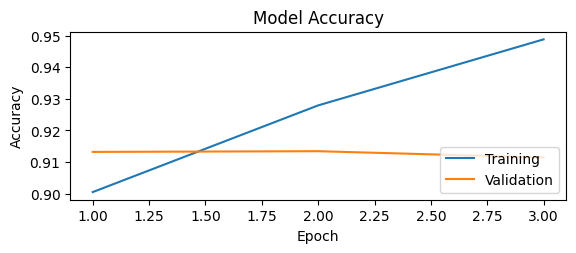

In [30]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

plt.figure(1)

plt.subplot(211)
plt.plot(range(1, len(acc) + 1), acc, label='Training')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

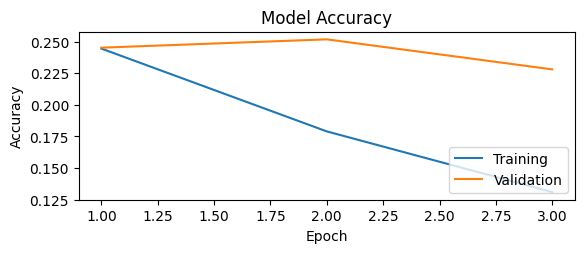

In [31]:
acc = model.history.history['loss']
val_acc = model.history.history['val_loss']

plt.figure(1)

plt.subplot(211)
plt.plot(range(1, len(acc) + 1), acc, label='Training')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()